# Import packages

In [1]:
import mne
import numpy as np
import scipy
from scipy.signal import savgol_filter
from scipy.stats import trim_mean
from sklearn.manifold import MDS, TSNE
from sklearn.cluster import KMeans
from sklearn.covariance import shrunk_covariance
import copy

import torch
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
from pylab import mpl
import seaborn as sns
import dill

import warnings
warnings.filterwarnings('ignore')

from utils import UDEC_Network, draw_states, ttest_for_clusters

In [2]:
plt.rcParams['font.family']=['Arial', 'Times New Roman']
plt.style.use('default')
mpl.rcParams["axes.unicode_minus"] = False
%config InlineBackend.figure_format = 'svg'

font = {'family':['Arial', 'Times New Roman'], 'color':'k', 'weight':'normal', 'size':10 }
colors = sns.color_palette('tab10')

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

mne.cuda.init_cuda(verbose=True)

cuda:0
Now using CUDA device 0
Enabling CUDA with 10.09 GB available memory


# Load EEG data

In [4]:
subject_num = 40
erp_data = np.zeros((subject_num, 2, 28, 256)) # [subject, type, ch, time]

trim = lambda x: trim_mean(x, 0.2, axis=0)

file_path_pre = './N400_Data/'
file_path_post = '_N400_shifted_ds_reref_ucbip_hpfilt_ica_corr_cbip_elist_bins_epoch_interp_ar.set'

for sub in range(subject_num):
    if (sub+1) in [1,3,9,16,23,25,27,28,29,40]: #[3,16,23,28,40]: #
        continue

    file_name = file_path_pre + str(sub+1) + file_path_post
    # from -200 ms to 800 ms, baseline correction performed
    epo = mne.io.read_epochs_eeglab(file_name);
    
    # epo.ch_names
    eog_ch_list = ['HEOG_left', 'HEOG_right', 'VEOG_lower', '(corr) HEOG',
                    '(corr) VEOG', '(uncorr) HEOG', '(uncorr) VEOG']
    epo.drop_channels(eog_ch_list);

    reject = dict(eeg=100e-6 )      # unit: V (EEG channels)
    flat_criteria = dict(eeg=1e-6)
    epo.drop_bad(reject, flat=flat_criteria, verbose=False);
    # epo.plot_drop_log();
    # epo.plot(events=True);

    events_dict = { }
    for word in ['unrela', 'rela']:
        events_dict[word] = []

    for id in epo.event_id:
        # Bin 1 Unrelated
        # Bin 2 Related
        if id[1] == '1':
            events_dict['unrela'].append(id)
        elif id[1] == '2':
            events_dict['rela'].append(id)
        
    for i, word in enumerate(['unrela', 'rela']):
        erp_data[sub, i] = epo[events_dict[word]].average(method=trim).get_data()

Extracting parameters from e:\论文写作\论文2数据分析\N400 - 副本\N400_Data\2_N400_shifted_ds_reref_ucbip_hpfilt_ica_corr_cbip_elist_bins_epoch_interp_ar.set...
Not setting metadata
108 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from e:\论文写作\论文2数据分析\N400 - 副本\N400_Data\4_N400_shifted_ds_reref_ucbip_hpfilt_ica_corr_cbip_elist_bins_epoch_interp_ar.set...
Not setting metadata
113 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from e:\论文写作\论文2数据分析\N400 - 副本\N400_Data\5_N400_shifted_ds_reref_ucbip_hpfilt_ica_corr_cbip_elist_bins_epoch_interp_ar.set...
Not setting metadata
113 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from e:\论文写作\论文2数据分析\N400 - 副本\N400_Data\6_N400_shifted_ds_reref_ucbip_hpfilt_ica_corr_cbip_elist_bins_epoch_interp_ar.set...
Not setting metadata
111 matching events found
No baseline correct

In [6]:
erp_data_mean = np.mean(erp_data, axis=0) #[2, 28, 256]

erp_data_norm = erp_data_mean * 1e6

sub_num = erp_data.shape[0]
type_num = erp_data_mean.shape[0]
ch_num = erp_data_mean.shape[1]
time_num = erp_data_mean.shape[2]

print(erp_data_mean.shape)

(2, 28, 256)


# Plot ERP

In [7]:
info_tmp = mne.create_info(ch_names=epo.ch_names, sfreq=256, ch_types='eeg')

erp1 = mne.EvokedArray(erp_data_mean[0], info_tmp, tmin=-0.2, nave=None)
erp1.set_montage(epo.get_montage());

erp2 = mne.EvokedArray(erp_data_mean[1], info_tmp, tmin=-0.2, nave=None)
erp2.set_montage(epo.get_montage());

erp_diff = mne.EvokedArray(erp_data_mean[0]-erp_data_mean[1], info_tmp, tmin=-0.2, nave=None)
erp_diff.set_montage(epo.get_montage());

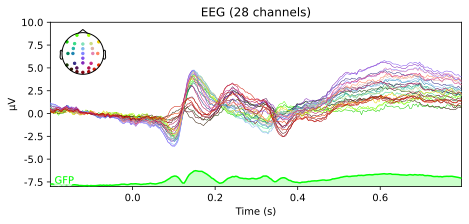

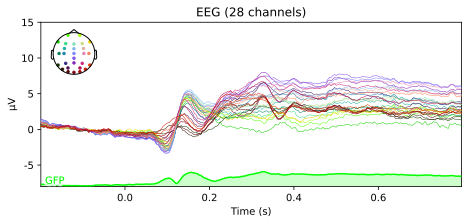

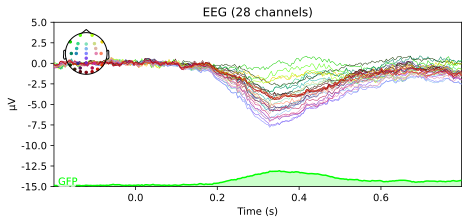

In [8]:
fig = erp1.plot(gfp=True, ylim = dict(eeg=[-8, 10]));

fig = erp2.plot(gfp=True, ylim = dict(eeg=[-8, 15]));

fig = erp_diff.plot(gfp=True, ylim = dict(eeg=[-15, 5]));

No projector specified for this dataset. Please consider the method self.add_proj.


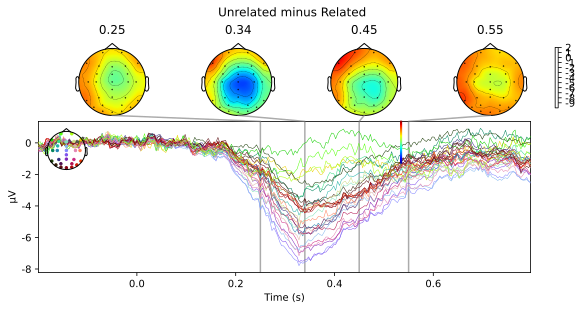

In [9]:
tp_args = { "vlim":(-10, 2), "time_format":'%3.2f', "contours":10, "cmap":"jet" }
erp_diff.plot_joint(title='Unrelated minus Related', times=[0.25, 0.34, 0.45, 0.55], topomap_args=tp_args); 

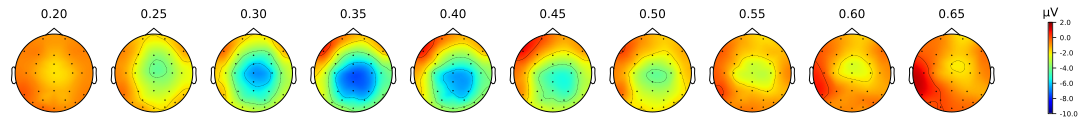

In [10]:
erp_diff.plot_topomap(cmap="jet", vlim=[-10, 2], time_format='%3.2f',
                      times=[0.2, 0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65], nrows=1 );

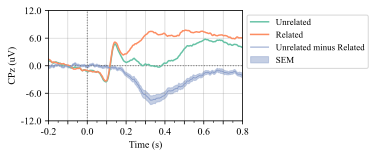

In [11]:
ch_index = epo.ch_names.index('CPz')

erp_data_1 = erp_data_mean[0][ch_index] * 1e6
erp_data_2 = erp_data_mean[1][ch_index] * 1e6

n_sub = erp_data.shape[0] # [40, 2, 28, 256] 
erp_data_diff_sem = np.std((erp_data[:,0,ch_index]-erp_data[:,1,ch_index]) * 1e6, axis=0, ddof=0)/np.sqrt(n_sub)

colors = sns.color_palette('Set2')

plt.figure(figsize=(3.5, 2))

ax = plt.gca()
# ax.axvspan(0, 100, alpha=0.1, color='grey')
plt.grid(color='gray', linewidth=0.5, alpha=0.5, linestyle='-')
plt.axhline(0.0, color='k', linewidth=1.0, linestyle=':', alpha=0.5)
plt.axvline(51.2, color='k', linewidth=1.0, linestyle=':', alpha=0.5)

# filter
mean_line1 = savgol_filter(erp_data_1, 4, 2) # win_size: 4, order: 3
mean_line2 = savgol_filter(erp_data_2, 4, 2) # win_size: 4, order: 3

diff_line = mean_line1 - mean_line2
sem_line1 = diff_line - erp_data_diff_sem
sem_line2 = diff_line + erp_data_diff_sem

plt.plot(mean_line1, label='Unrelated', color=colors[0])    
plt.plot(mean_line2, label='Related', color=colors[1])
plt.plot(diff_line, label='Unrelated minus Related', linewidth=1.0, color=colors[2])

plt.fill_between(range(256), sem_line1, sem_line2, alpha=0.5, label='SEM', color=colors[2] )    

ax.xaxis.set_minor_locator(MultipleLocator(12.8))
plt.xlim([0,256])
plt.ylim([-12, 12])
    
plt.legend(prop={'family':'Times New Roman', 'size':9}, ncol = 1, bbox_to_anchor=(1.0, 1.0))

font = {'family' : 'Times New Roman', # 'Microsoft YaHei' 'SimHei' 'serif' 
        'color'  : 'k',
        'weight' : 'normal',
        'size'   : 10,
        }

plt.xticks(np.linspace(0, 256, 11, endpoint=True), ['-0.2', '',  '0.0', '', '0.2', '', '0.4', '', '0.6', '', '0.8'], fontdict=font);
# ['-0.2', '-0.1',  '0.0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8']
plt.xlabel("Time (s)", fontdict=font)
plt.yticks(np.linspace(-12, 12, 5, endpoint=True), np.linspace(-12, 12, 5, endpoint=True), fontdict=font);
plt.ylabel("CPz (uV)", fontdict=font);


# Calculate spatial covariance matrix

In [12]:
# time [-0.2, 0.8] 256Hz 
# epo.time_as_index(0.0)  51
# epo.time_as_index(0.7)  231
# slide_window 0.1s [-12, 12]

half_win = 12

start_t = 51
end_t = 231
len_t = 180

cov_mat = 0
cov_diag = 0
cov_data = 0
crop_erp = 0

flag = 0
for tp in range(type_num):

    data = erp_data_norm[tp]

    cov_mat_epoch = np.empty((len_t, ch_num, ch_num))
    cov_data_epoch = np.empty(( len_t, int(ch_num*((ch_num+1)/2)) ))
    cov_diag_epoch = np.empty(( len_t, ch_num ))

    for ind, t in enumerate(range(start_t, end_t)):
        # calculate covariance matrix
        cov = np.cov(data[:, t-half_win:t+half_win])
        # get the triangle elements of the matrix
        cov_data_epoch[ind] = cov[np.triu_indices(cov.shape[0], k=0)]
        cov_diag_epoch[ind] = np.diagonal(cov)
        # shrunk
        cov = shrunk_covariance(cov, shrinkage=0.01)
        cov_mat_epoch[ind] = cov
                
    if flag == 0:
        flag = 1
        cov_mat = cov_mat_epoch
        cov_diag = cov_diag_epoch
        cov_data = cov_data_epoch
        crop_erp = erp_data_mean[tp, :, start_t:end_t].T
    else:
        cov_data = np.vstack((cov_data, cov_data_epoch))
        cov_diag = np.vstack((cov_diag, cov_diag_epoch))
        cov_mat = np.vstack((cov_mat, cov_mat_epoch))
        crop_erp = np.vstack((crop_erp, erp_data_mean[tp, :, start_t:end_t].T))

print( crop_erp.shape ) # [times, chs]
print( cov_mat.shape )  # [times, chs, chs]
print( cov_diag.shape ) # [times, chs]
print( cov_data.shape ) # [times, diag]
print( type_num*len_t, int(ch_num*((ch_num+1)/2)) ) # 360 = 2 * 180

(360, 28)
(360, 28, 28)
(360, 28)
(360, 406)
360 406


In [13]:
with open('./tmp_data/raw_eeg_data.pkl', 'wb') as f:
    dill.dump([erp_data, erp_data_mean, cov_mat, cov_data, cov_diag, crop_erp], f)

# with open('./tmp_data/raw_eeg_data.pkl', 'rb') as f:
#     [erp_data, erp_data_mean, cov_mat, cov_data, cov_diag, crop_erp] = dill.load(f)

## Plot covariance matrices

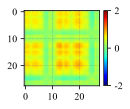

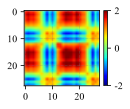

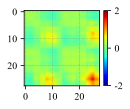

In [14]:
def draw_cov_mat(ind):
    fig, ax = plt.subplots(figsize=(1.5, 1.5))
    ax0 = ax.matshow(cov_mat[ind], interpolation='none', vmin=-2, vmax=2.0, cmap='jet');# cmap='turbo', 
    clb = fig.colorbar(ax0, fraction=0.045);
    ax.xaxis.set_ticks_position("bottom")
    plt.grid(color='gray', linestyle=':', linewidth=0.5);
    clb.set_ticks(ticks=[-2, 0, 2])
    cbar_label = clb.ax.get_xticklabels() + clb.ax.get_yticklabels()
    [lab.set_font('Times New Roman') for lab in cbar_label]  #Times New Roman Arial
    clb.ax.tick_params(labelsize=10)
    ax.set_xticks(np.arange(0,30,10), np.arange(0,30,10), fontdict=font);
    ax.set_yticks(np.arange(0,30,10), np.arange(0,30,10), fontdict=font);
    plt.show();

tps = [20, 50, 80]
for tp in tps:
    draw_cov_mat(tp)

# Calculate spatial pattern distance

## distance in observation space

In [15]:
%%writefile calc_dist_o_fun.py

import scipy
import numpy as np

def calc_dist_o(cov1, cov2):
    evals, _ = scipy.linalg.eigh(cov1,cov2)
    res = evals[-1] #np.max(evals) 
    
    return res

Overwriting calc_dist_o_fun.py


In [16]:
import calc_dist_o_fun
import multiprocessing

num_cores = int(multiprocessing.cpu_count())

print("CPU cores: ", num_cores)

CPU cores:  32


In [17]:
tp = cov_mat.shape[0]

cov_dist_o = np.full((tp, tp), np.nan)

for i in range(tp):
    if i % 200 == 0: # ~3min
        print(i)
 
    pool = multiprocessing.Pool(processes = num_cores)
    res = []
    for j in range(i+1, tp):        
        r = pool.apply_async(calc_dist_o_fun.calc_dist_o, args=( cov_mat[i], cov_mat[j] )) 
        res.append(r)

    pool.close()

    evals_i = np.squeeze( [p.get() for p in res] )
    cov_dist_o[i, i+1:] = evals_i

0
200


In [18]:
# with open('./tmp_data/cov_dist_o.pkl', 'wb') as f:
#     dill.dump(cov_dist_o, f)

with open('./tmp_data/cov_dist_o.pkl', 'rb') as f:
    cov_dist_o = dill.load(f)

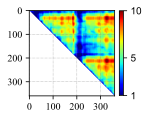

In [19]:
fig, ax = plt.subplots(figsize=(1.7, 1.7))
ax0 = ax.matshow(np.log(cov_dist_o), interpolation='none', vmin=1.0, vmax=10.0, cmap='jet');
clb = fig.colorbar(ax0, fraction=0.045);
ax.xaxis.set_ticks_position("bottom")
plt.grid(color='gray', linestyle=':', linewidth=0.5);
clb.set_ticks(ticks=[1, 5, 10])
cbar_label = clb.ax.get_xticklabels() + clb.ax.get_yticklabels()
[lab.set_font('Arial') for lab in cbar_label]  #Times New Roman  #set_fontstyle
clb.ax.tick_params(labelsize=10)
ax.set_xticks(np.arange(0,400,100), np.arange(0,400,100), fontdict=font);
ax.set_yticks(np.arange(0,400,100), np.arange(0,400,100), fontdict=font);
plt.show();

In [20]:
norm_cov_dist_o = np.log(cov_dist_o)
norm_cov_dist_o /= (np.nanmax(norm_cov_dist_o))

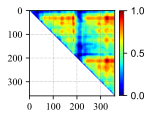

In [21]:
fig, ax = plt.subplots(figsize=(1.7, 1.7))
ax0 = ax.matshow(norm_cov_dist_o, interpolation='none', vmin=0.0, vmax=1.0, cmap='jet', );
clb = fig.colorbar(ax0, fraction=0.045);
ax.xaxis.set_ticks_position("bottom")
plt.grid(color='gray', linestyle=':', linewidth=0.5);
clb.set_ticks(ticks=[0, 0.5, 1])
cbar_label = clb.ax.get_xticklabels() + clb.ax.get_yticklabels()
[lab.set_font('Arial') for lab in cbar_label] 
clb.ax.tick_params(labelsize=10)
ax.set_xticks(np.arange(0,400,100), np.arange(0,400,100), fontdict=font);
ax.set_yticks(np.arange(0,400,100), np.arange(0,400,100), fontdict=font);
plt.show();

## distance in source space

In [22]:
%%writefile calc_dist_s_fun.py

import scipy
import numpy as np

def calc_dist_s(cov1, cov2):

    d2 = (np.log(scipy.linalg.eigvalsh(cov1,cov2))**2).sum(axis=-1)
    riemann_dist = np.sqrt(d2) 
    
    return riemann_dist

Overwriting calc_dist_s_fun.py


In [23]:
import calc_dist_s_fun
import multiprocessing

num_cores = int(multiprocessing.cpu_count())

print("CPU cores: ", num_cores)

CPU cores:  32


In [24]:
tp = cov_mat.shape[0]

cov_dist_s = np.full((tp, tp), np.nan)

for i in range(tp):
    if i % 200 == 0: # ~3min
        print(i)

    pool = multiprocessing.Pool(processes = num_cores)
    res = []
    for j in range(i+1, tp):        
        r = pool.apply_async(calc_dist_s_fun.calc_dist_s, args=( cov_mat[i], cov_mat[j] ))
        res.append(r)

    pool.close()

    riemann_dist_i = np.squeeze( [p.get() for p in res] )
    cov_dist_s[i, i+1:] = riemann_dist_i

0
200


In [25]:
# with open('./tmp_data/cov_dist_s.pkl', 'wb') as f:
#     dill.dump(cov_dist_s, f)

with open('./tmp_data/cov_dist_s.pkl', 'rb') as f:
    cov_dist_s = dill.load(f)

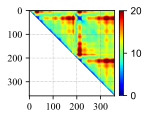

In [26]:
fig, ax = plt.subplots(figsize=(1.7, 1.7))
ax0 = ax.matshow(cov_dist_s, interpolation='none', vmin=0.0, vmax=20.0, cmap='jet', );# 
clb = fig.colorbar(ax0, fraction=0.045);
ax.xaxis.set_ticks_position("bottom")
plt.grid(color='gray', linestyle=':', linewidth=0.5);
clb.set_ticks(ticks=[0, 10, 20])
cbar_label = clb.ax.get_xticklabels() + clb.ax.get_yticklabels()
[lab.set_font('Arial') for lab in cbar_label]  #Times New Roman  #set_fontstyle
clb.ax.tick_params(labelsize=10)

ax.set_xticks(np.arange(0,400,100), np.arange(0,400,100), fontdict=font);
ax.set_yticks(np.arange(0,400,100), np.arange(0,400,100), fontdict=font);
plt.show();

In [27]:
norm_cov_dist_s = copy.deepcopy(cov_dist_s)
norm_cov_dist_s /= (np.nanmax(norm_cov_dist_s))

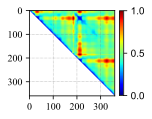

In [28]:
fig, ax = plt.subplots(figsize=(1.7, 1.7))
ax0 = ax.matshow(norm_cov_dist_s, interpolation='none', vmin=0.0, vmax=1.0, cmap='jet', );
clb = fig.colorbar(ax0, fraction=0.045);
ax.xaxis.set_ticks_position("bottom")
plt.grid(color='gray', linestyle=':', linewidth=0.5);
clb.set_ticks(ticks=[0, 0.5, 1])
cbar_label = clb.ax.get_xticklabels() + clb.ax.get_yticklabels()
[lab.set_font('Arial') for lab in cbar_label]
clb.ax.tick_params(labelsize=10)

ax.set_xticks(np.arange(0,400,100), np.arange(0,400,100), fontdict=font);
ax.set_yticks(np.arange(0,400,100), np.arange(0,400,100), fontdict=font);
plt.show();

# Multi-dimensional Scaling

In [29]:
norm_dist_o_symm = np.ones_like(norm_cov_dist_o)
for i in range(norm_cov_dist_o.shape[0]):
    for j in range(i+1, norm_cov_dist_o.shape[0]):
        norm_dist_o_symm[i,j] = norm_cov_dist_o[i,j]
        norm_dist_o_symm[j,i] = norm_cov_dist_o[i,j]

mds = MDS(n_components=28, dissimilarity='precomputed', metric=True, 
          n_jobs=32, random_state=3, normalized_stress='auto') 
features_dist_o = mds.fit_transform(norm_dist_o_symm)

features_dist_o.shape

(360, 28)

In [30]:
norm_dist_s_symm = np.ones_like(norm_cov_dist_s)
for i in range(norm_cov_dist_s.shape[0]):
    for j in range(i+1, norm_cov_dist_s.shape[0]):
        norm_dist_s_symm[i,j] = norm_cov_dist_s[i,j]
        norm_dist_s_symm[j,i] = norm_cov_dist_s[i,j]

mds = MDS(n_components=28, dissimilarity='precomputed', metric=True, 
          n_jobs=32, random_state=3, normalized_stress='auto')
features_dist_s = mds.fit_transform(norm_dist_s_symm)

features_dist_s.shape 

(360, 28)

In [31]:
# with open('./tmp_data/distance_mds_data.pkl', 'wb') as f:
#     dill.dump([features_dist_o, features_dist_s], f)

with open('./tmp_data/distance_mds_data.pkl', 'rb') as f:
    [features_dist_o, features_dist_s] = dill.load(f)

# Data normlization

In [32]:
norm_cov_diag = np.log(10*cov_diag)

norm_dist_o = 20*features_dist_o

norm_dist_s = 20*features_dist_s

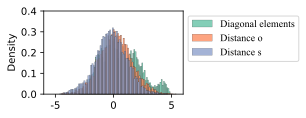

In [33]:
import warnings
warnings.filterwarnings('ignore')

font = {'family':['Times New Roman', 'Arial', ], 'weight':'normal', 'size':10 }
colors = sns.color_palette('Set2')

plt.figure(figsize=(2.5, 1.5))

sns.histplot(norm_cov_diag.flatten(), bins=80, stat='density', legend=False, color=colors[0], alpha=0.8, )
sns.histplot(norm_dist_o.flatten()+0.2, bins=80, stat='density', legend=False, color=colors[1], alpha=0.8, )
sns.histplot(norm_dist_s.flatten()-0.2, bins=80, stat='density', legend=False, color=colors[2], alpha=0.8, )

plt.xlim([-6, 6])
plt.ylim([0, 0.4])

plt.legend(labels=['Diagonal elements', 'Distance o', 'Distance s'], prop=font, bbox_to_anchor=(1.0, 1.0));

In [34]:
input_data_raw = np.hstack((norm_cov_diag, norm_dist_o, norm_dist_s))
print(input_data_raw.shape) #[360, 84]

input_data = torch.from_numpy(input_data_raw).type(torch.FloatTensor) #[samples, features]

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

(360, 84)
cuda:0


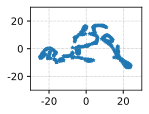

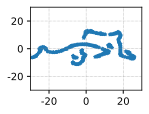

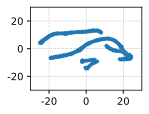

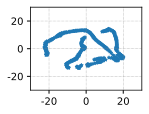

In [35]:
tsne = TSNE(n_components=2, init='pca', random_state=0, n_jobs=-1, perplexity=30)

for data in [norm_cov_diag, norm_dist_o, norm_dist_s, input_data_raw]:
    tsne_2d = tsne.fit_transform(data)

    fig, axi1=plt.subplots(1, figsize=(2, 1.5))    
    axi1.scatter(tsne_2d[:, 0], tsne_2d[:, 1],
                marker='*', s=10, color=sns.color_palette('Paired')[1],
                )

    ax = plt.gca()
    plt.grid(True, linewidth=0.5, color='gray', linestyle=':')
    plt.xlim([-30, 30])
    plt.ylim([-30, 30])
    # plt.yticks([-100,-50,0,50,100],[-100,-50,0,50,100])
    # plt.xticks([-100,-50,0,50,100],[-100,-50,0,50,100])

    ax.tick_params(which='both', bottom=True, top=False, left=True, right=False,
                labelbottom=True, labelleft=True, direction='out',width=1)
    plt.show()

In [36]:
# with open('./tmp_data/network_input_data.pkl', 'wb') as f:
#     dill.dump([norm_cov_diag, norm_dist_o, norm_dist_s, input_data_raw], f)

with open('./tmp_data/network_input_data.pkl', 'rb') as f:
    [norm_cov_diag, norm_dist_o, norm_dist_s, input_data_raw] = dill.load(f)

# Train AutoEncoder Network

In [37]:
# import importlib
# importlib.reload(UDEC_Network)

EPOCHS_PRE = 3001
LR_PRE = 5e-3 # dynamic adjust learning rate
BATCH_SIZE = 32

autoencoder = UDEC_Network.AutoEncoder().to(device)
checkpoint = { "epoch": 0, "best": float("inf") }
file_path_prefix = './network_data/'
ae_save_path = file_path_prefix + 'autoencoder.pth'

UDEC_Network.pretrain(data=input_data, model=autoencoder, savepath=ae_save_path, 
                      checkpoint=checkpoint, file_path_prefix=file_path_prefix, 
                      num_epochs=EPOCHS_PRE, batch_size=BATCH_SIZE, lr=LR_PRE)

epoch [1/3001], MSE_loss:1.66254
epoch [2/3001], MSE_loss:1.13898
epoch [3/3001], MSE_loss:1.01787
epoch [4/3001], MSE_loss:0.96542
epoch [5/3001], MSE_loss:0.83371
epoch [6/3001], MSE_loss:1.01575
epoch [7/3001], MSE_loss:0.92843
epoch [8/3001], MSE_loss:0.80495
epoch [9/3001], MSE_loss:0.81596
epoch [10/3001], MSE_loss:0.77381
epoch [11/3001], MSE_loss:0.74888
epoch [12/3001], MSE_loss:0.58345
epoch [13/3001], MSE_loss:0.74370
epoch [14/3001], MSE_loss:0.50986
epoch [15/3001], MSE_loss:0.61735
epoch [16/3001], MSE_loss:0.48200
epoch [17/3001], MSE_loss:0.49468
epoch [18/3001], MSE_loss:0.51220
epoch [19/3001], MSE_loss:0.41671
epoch [20/3001], MSE_loss:0.28173
epoch [21/3001], MSE_loss:0.30446
epoch [22/3001], MSE_loss:0.36370
epoch [23/3001], MSE_loss:0.30576
epoch [24/3001], MSE_loss:0.44834
epoch [25/3001], MSE_loss:0.24842
epoch [26/3001], MSE_loss:0.43508
epoch [27/3001], MSE_loss:0.55455
epoch [28/3001], MSE_loss:0.45840
epoch [29/3001], MSE_loss:0.23072
epoch [30/3001], MSE_lo

## latent features visualization

In [38]:
input_data_device = input_data.to(device)

latent_features = autoencoder.encode(input_data_device).detach().cpu().numpy()

print(latent_features.shape)

(360, 16)


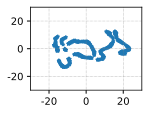

In [39]:
tsne = TSNE(n_components=2, init='pca', random_state=0, n_jobs=-1, perplexity=30)

tsne_2d = tsne.fit_transform(latent_features)

fig, axi1=plt.subplots(1, figsize=(2, 1.5))
axi1.scatter(tsne_2d[:, 0], tsne_2d[:, 1],
            marker='*', s=10, color=sns.color_palette('Paired')[1],
            )

ax = plt.gca()
plt.grid(True, linewidth=0.5, color='gray', linestyle=':')
plt.xlim([-30, 30])
plt.ylim([-30, 30])
# plt.yticks([-100,-50,0,50,100],[-100,-50,0,50,100])
# plt.xticks([-100,-50,0,50,100],[-100,-50,0,50,100])

ax.tick_params(which='both', bottom=True, top=False, left=True, right=False,
            labelbottom=True, labelleft=True, direction='out',width=1)
plt.show()

# Train clustering network

In [40]:
tmp = copy.deepcopy(input_data_raw)

np.random.shuffle(tmp)
np.random.shuffle(tmp)

data_shuffle = torch.from_numpy(tmp).type(torch.FloatTensor)

In [42]:
EPOCHS = 10001
BATCH_SIZE = 512
lr = 0.6
file_path_prefix = './network_data/'

for ind, n_c in enumerate([6, 8, 10]): # 

    autoencoder = UDEC_Network.AutoEncoder().to(device)
    ae_save_path = file_path_prefix + 'autoencoder.pth'
    checkpoint = torch.load(ae_save_path)
    autoencoder.load_state_dict(checkpoint['state_dict'])

    dec = UDEC_Network.DEC(n_clusters=n_c, autoencoder=autoencoder, hidden=16, cluster_centers=None, alpha=1.0).to(device)

    dec_save_path = file_path_prefix + 'dec-' + str(n_c) + '-clusters' + '.pth'
    checkpoint = { "epoch": 0, "best": float("inf") }
    UDEC_Network.train(data=data_shuffle, model=dec, num_epochs=EPOCHS, 
                       n_cluster=n_c, draw_pic=True, lr=lr, file_path_prefix=file_path_prefix, 
                       savepath=dec_save_path, checkpoint=checkpoint, batch_size=BATCH_SIZE)

Training
plotting
Epochs: [0/10001] Loss:0.197330504655838
Epochs: [1000/10001] Loss:0.011421783827245235
Epochs: [2000/10001] Loss:0.00821361131966114
Epochs: [3000/10001] Loss:0.006751133594661951
Epochs: [4000/10001] Loss:0.005868184845894575
plotting
Epochs: [5000/10001] Loss:0.005261091515421867
Epochs: [6000/10001] Loss:0.004810708109289408
Epochs: [7000/10001] Loss:0.004459407180547714
Epochs: [8000/10001] Loss:0.004175422713160515
Epochs: [9000/10001] Loss:0.003939704969525337
plotting
Epochs: [10000/10001] Loss:0.0037399560678750277
Training
plotting
Epochs: [0/10001] Loss:0.23771421611309052
Epochs: [1000/10001] Loss:0.016643472015857697
Epochs: [2000/10001] Loss:0.011941717006266117
Epochs: [3000/10001] Loss:0.009803962893784046
Epochs: [4000/10001] Loss:0.00851544737815857
plotting
Epochs: [5000/10001] Loss:0.007630394771695137
Epochs: [6000/10001] Loss:0.00697431992739439
Epochs: [7000/10001] Loss:0.006462802179157734
Epochs: [8000/10001] Loss:0.006049491930752993
Epochs: 

# K-Means clustering of latent features 

In [43]:
data = torch.from_numpy(input_data_raw).type(torch.FloatTensor)

num_clusters = [6, 8, 10]

latent_vec = np.empty( (len(num_clusters), data.size()[0], 16) )  # [n_c, frames, n_hidden]
pred_label = np.empty( (len(num_clusters), data.size()[0]) )
pred_center = []

file_path_prefix = './network_data/'
for ind, n_c in enumerate(num_clusters): 

    # load model
    autoencoder = UDEC_Network.AutoEncoder()

    dec = UDEC_Network.DEC(n_clusters=n_c, autoencoder=autoencoder, hidden=16, cluster_centers=None, alpha=1.0)
    dec_save_path = file_path_prefix + 'dec-' + str(n_c) + '-clusters' + '.pth'
    checkpoint = torch.load(dec_save_path)
    dec.load_state_dict(checkpoint['state_dict']);

    # calculate latent vectors
    latent_vec[ind] = dec.autoencoder.encode(input_data).detach().cpu().numpy()

    # get cluster centers
    cluster = KMeans(n_clusters=num_clusters[ind], random_state=0, n_init=10*num_clusters[ind]).fit(latent_vec[ind])

    # get cluster labels
    centroid = cluster.cluster_centers_
    pred_center.append(centroid)
    pred_label[ind] = cluster.labels_ 

pred_label += 1

In [44]:
# with open('./tmp_data/eeg_data_udec_clustering_results.pkl', 'wb') as f:
#     dill.dump([pred_center, pred_label, centroid, latent_vec], f)

In [43]:
with open('./tmp_data/eeg_data_udec_clustering_results.pkl', 'rb') as f:
    [pred_center, pred_label, centroid, latent_vec] = dill.load(f)

# T-SNE visualization

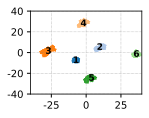

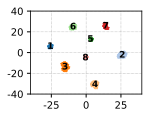

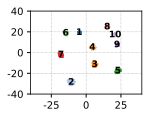

In [45]:
tsne = TSNE(n_components=2, init='pca', random_state=0, n_jobs=-1, perplexity=30)

colors = sns.color_palette('pastel')

for ind, n_c in enumerate(num_clusters): 

    lf_with_center = np.vstack((latent_vec[ind], pred_center[ind]))

    kmeans_2d_with_center = tsne.fit_transform(lf_with_center)    
    kmeans_2d = kmeans_2d_with_center[:-n_c, :]
    kmeans_2d_center = kmeans_2d_with_center[-n_c:, :]

    fig, axi1=plt.subplots(1, figsize=(2, 1.5))    
    for i in range(n_c):
        axi1.scatter( kmeans_2d[pred_label[ind] == i+1, 0], 
                      kmeans_2d[pred_label[ind] == i+1, 1],
                      marker='*',
                      s=10,
                      color=plt.cm.tab20(i%20),
                    )
        axi1.text(kmeans_2d_center[i,0], kmeans_2d_center[i,1], 
                  i+1, fontsize=9, fontweight='semibold', 
                  verticalalignment='center', horizontalalignment='center', 
                  color='black', 
                )

    ax = plt.gca()
    plt.grid(True, linewidth=0.5, color='gray', linestyle=':')
    plt.xlim([-40, 40])
    plt.ylim([-40, 40])
    # plt.yticks([-100,-50,0,50,100],[-100,-50,0,50,100])
    # plt.xticks([-100,-50,0,50,100],[-100,-50,0,50,100])

    ax.tick_params(which='both', bottom=True, top=False, left=True, right=False,
                labelbottom=True, labelleft=True, direction='out',width=1)
    plt.show()

# Find index of cluster centers

In [46]:
euc_center_index = []
rie_center_index = []

num_clusters = [6, 8, 10]

riemann_dist_symmetry = np.zeros_like(cov_dist_s)
for i in range(cov_dist_s.shape[0]):
    for j in range(i+1, cov_dist_s.shape[0]):
        riemann_dist_symmetry[i,j] = cov_dist_s[i,j]
        riemann_dist_symmetry[j,i] = cov_dist_s[i,j]

# Euclidean distance of lantent vectors
for i, n_c in enumerate(num_clusters):
    tmp_c = []
    for n in range(n_c):
        distance = np.sum(np.square(latent_vec[i][pred_label[i]==(n+1)] - pred_center[i][n]), axis=1)
        index = distance.argmin()
        tmp_c.append( np.argwhere(pred_label[i]==(n+1))[index][0] )
    euc_center_index.append(tmp_c)

# Riemann distance
for i, n_c in enumerate(num_clusters):
    tmp_c = []
    for n in range(n_c):

        tmp = riemann_dist_symmetry[pred_label[i]==(n+1), :]
        tmp2 = tmp[:, pred_label[i]==(n+1)]
        distance = np.sum(tmp2, axis=0)

        index = distance.argmin()
        tmp_c.append( np.argwhere(pred_label[i]==(n+1))[index][0] )
    rie_center_index.append(tmp_c)

In [47]:
print(euc_center_index[1])

print(rie_center_index[1])

[7, 260, 160, 348, 224, 208, 81, 131]
[12, 272, 151, 341, 229, 28, 81, 120]


In [68]:
clu_index = 2 # 10 clusters

cog_condition = [] # 2 conditions
time_index = [] # 0-180 time window

for ci in rie_center_index[clu_index]:
    cog_condition.append( 1+int(ci/180) )
    time_index.append( ci%180 )

In [69]:
print(cog_condition)

print(time_index)

[1, 2, 2, 1, 2, 1, 1, 1, 2, 1]
[16, 92, 53, 173, 161, 31, 81, 148, 122, 120]


# t-test of clustering results

[]


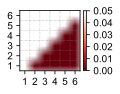

[]


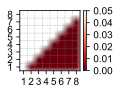

[]


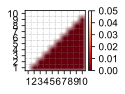

In [52]:
for n_c in range(len(num_clusters)):
    p_res = ttest_for_clusters.distance_ttest(pred_label[n_c], cov_dist_s, samp_num=500)
    ttest_for_clusters.draw_test_mat(p_res, corr_p=True)

# Plot microstate series

In [63]:
cluster_number_index = 2 # 10 clusters

each_condition_label = np.full((2, 180), np.nan)

type_num = 2
for tp in range(type_num):
    st = tp*180
    ed = st+180
    
    each_condition_label[tp] = pred_label[cluster_number_index, st:ed]

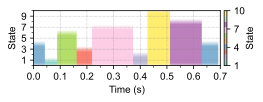

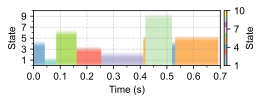

In [64]:
for sym in range(type_num):
    draw_states.draw_state_blocks_for_eeg(each_condition_label[sym], figsize=(3.5, 1.0), n_clusters=10,
                                          #  n_clusters=int(np.max(each_condition_label[sym])),
                                          colorbar_fraction=0.015, tmin=0.0, tmax=0.7, 
                                          colorbar_ticks=[1,4,7,10]);

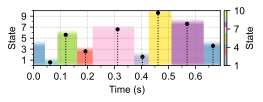

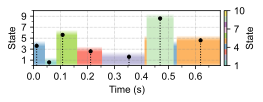

In [66]:
# importlib.reload(draw_states)
for sym in range(type_num):
    draw_states.draw_state_blocks_for_eeg(each_condition_label[sym], figsize=(3.5, 1.0), n_clusters=10,
                                          #  n_clusters=int(np.max(each_condition_label[sym])),
                                          colorbar_fraction=0.015, tmin=0.0, tmax=0.7, 
                                          colorbar_ticks=[1,4,7,10], rie_dist=cov_dist_s, current_cluster=sym);

# Draw center EEG topomap

In [70]:
cog_condition = [1, 2, 2, 1, 2, 1, 1, 1, 2, 1]
time_index = [16, 92, 53, 173, 161, 31, 81, 148, 122, 120]

In [71]:
# erp_data_mean [2, 28, 256]
half_win = 12
start_t = 51
end_t = 231
len_t = 180

eeg_state_centers = np.zeros((10, 28))

for i, cog_ind in enumerate(cog_condition):
    eeg_state_centers[i] = np.mean(erp_data_mean[cog_ind-1, :, ((time_index[i]+start_t)-half_win):((time_index[i]+start_t)+half_win)], axis=1)

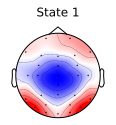

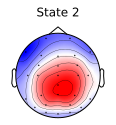

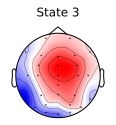

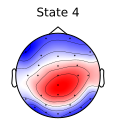

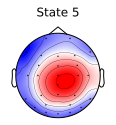

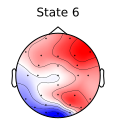

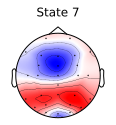

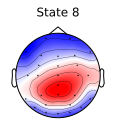

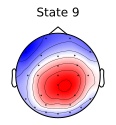

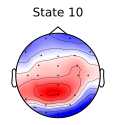

In [78]:
draw_states.draw_grand_average_topo(eeg_state_centers, epo, cmap='bwr', draw_separate=True, colorbar=False);

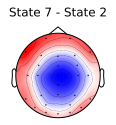

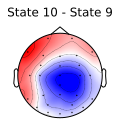

In [75]:
draw_states.draw_topo_diff(eeg_state_centers[6,:]-eeg_state_centers[1,:], epo, title='State 7 - State 2', cmap='bwr');

draw_states.draw_topo_diff(eeg_state_centers[9,:]-eeg_state_centers[8,:], epo, title='State 10 - State 9', cmap='bwr');

# draw_states.draw_topo_diff(eeg_state_centers[7,:]-eeg_state_centers[0,:], epo, title='State 8 - State 1', cmap='bwr');

# draw_states.draw_topo_diff(eeg_state_centers[3,:]-eeg_state_centers[9,:], epo, title='State 4 - State 10', cmap='bwr');

# draw_states.draw_topo_diff(eeg_state_centers[2,:]-eeg_state_centers[3,:], epo, title='State 3 - State 4', cmap='bwr');